# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, RocCurveDisplay, r2_score,\
    mean_absolute_error, mean_squared_error, recall_score, accuracy_score,\
    f1_score, precision_score, balanced_accuracy_score, roc_auc_score

import seaborn as sns

# Custom functions

In [2]:
from pickle_managment import load_pickle

# Regression

## Load pickles

In [3]:
best_rf_regressor = load_pickle(
    r'model_pickles\best_rf_regressor.pkl')

regression_X_train = load_pickle(
    r'model_outputs\rf_regressor\regression_X_train.pkl')
regression_y_train = load_pickle(
    r'model_outputs\rf_regressor\regression_y_train.pkl')
regression_X_test = load_pickle(
    r'model_outputs\rf_regressor\regression_X_test.pkl')
regression_y_test = load_pickle(
    r'model_outputs\rf_regressor\regression_y_test.pkl')

## Feature importance

In [4]:
importance = best_rf_regressor.feature_importances_.copy()  #Length of
# importance should be the same as your regression_X_train's number of features
non_zero_index_list = [i for i, v in enumerate(importance) if v != 0]  #Only
# care about the important ones

non_zero_feature_names = [regression_X_train.columns[i] for i in
                          non_zero_index_list]
non_zero_importance = [importance[i] for i in non_zero_index_list]

non_zero_importance_df = pd.DataFrame(
    data=dict(
        zip(
            ['Features', 'Importance'],
            [non_zero_feature_names, non_zero_importance]
        )
    )
)

non_zero_importance_df = non_zero_importance_df.sort_values(
    by='Importance',
    ascending=False
)
non_zero_importance_df = non_zero_importance_df.reset_index(drop=True)  #Reset
# the index and drop the old index
non_zero_importance_df = non_zero_importance_df.head(20)
non_zero_importance_df

,Features,Importance
0,TPSA,0.036547
1,NOCount,0.019486
2,MaxPartialCharge,0.016749
3,MinAbsPartialCharge,0.014968
4,VSA_EState2,0.014365
5,VSA_EState3,0.013787
6,146_y,0.012899
7,PEOE_VSA6,0.012149
8,NumHeteroatoms,0.012043
9,NumHAcceptors,0.011951


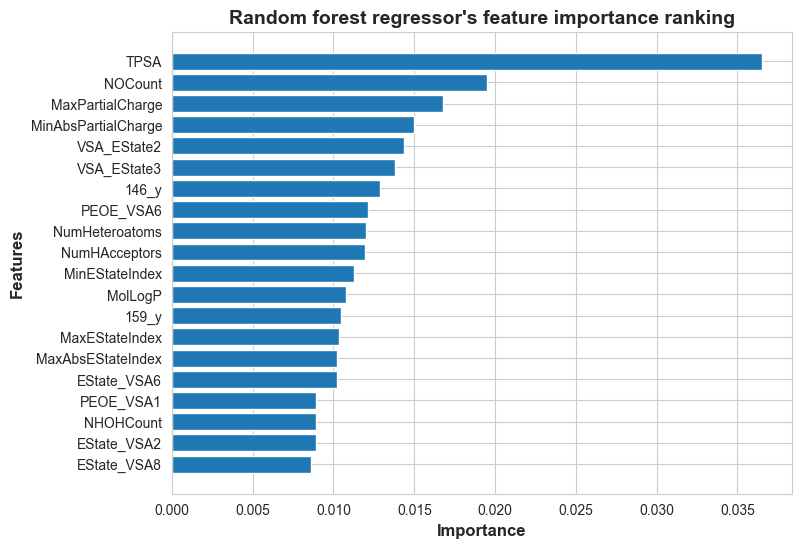

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(non_zero_importance_df['Features'],
         non_zero_importance_df['Importance'])

ax.invert_yaxis()  #Flip the y-axis so the most important feature is on the top

plt.xlabel('Importance', weight='bold', fontsize=12)
plt.ylabel('Features', weight='bold', fontsize=12)
plt.title("Random forest regressor's feature importance ranking",
          weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\rf_regressor\importance_ranking_vertical.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

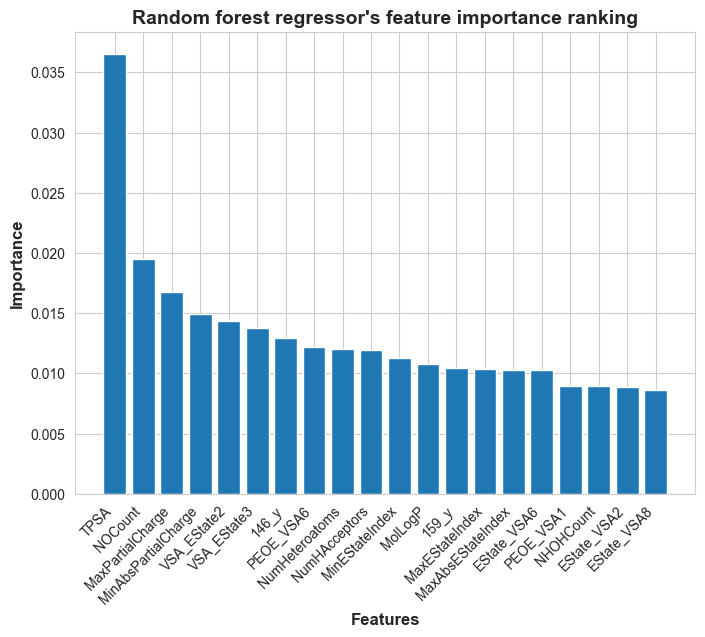

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(non_zero_importance_df['Features'],
        non_zero_importance_df['Importance'])

plt.xticks(rotation=45, ha='right')

plt.xlabel('Features', weight='bold', fontsize=12)
plt.ylabel('Importance', weight='bold', fontsize=12)
plt.title("Random forest regressor's feature importance ranking",
          weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\rf_regressor\importance_ranking_horizontal.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## Performance on train vs. test sets

In [7]:
mae_list = []
mse_list = []
r2_list = []
for data_X, data_y in [[regression_X_train, regression_y_train],
                       [regression_X_test, regression_y_test]]:
    y_predict = best_rf_regressor.predict(data_X)

    mae = mean_absolute_error(np.copy(data_y), y_predict)
    mse = mean_squared_error(np.copy(data_y), y_predict)
    r2 = r2_score(np.copy(data_y), y_predict)

    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)

performance_df = pd.DataFrame(
    {
        'Dataset': ['Train', 'Test'],
        'MAE': mae_list,
        'MSE': mse_list,
        'R2': r2_list
    }
)

performance_df_melted = performance_df.melt(id_vars='Dataset',
                                            var_name='Metric',
                                            value_name='Value')
performance_df_melted

,Dataset,Metric,Value
0,Train,MAE,0.316704
1,Test,MAE,0.397086
2,Train,MSE,0.178416
3,Test,MSE,0.266198
4,Train,R2,0.689916
5,Test,R2,0.508689


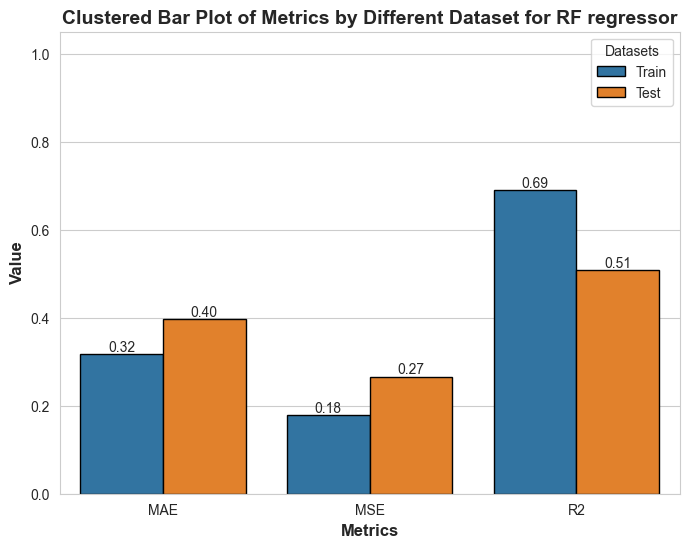

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.barplot(data=performance_df_melted, x='Metric', y='Value',
                 hue='Dataset',
                 edgecolor='black')

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.2f'  #Round the data label to the 2 decimal places
    )
plt.ylim(0, 1.05)
plt.xlabel('Metrics', weight='bold', fontsize=12)
plt.ylabel('Value', weight='bold', fontsize=12)
plt.title('Clustered Bar Plot of Metrics by Different Dataset for RF '
          'regressor',
          weight='bold', fontsize=14)
plt.legend(title='Datasets')

plt.savefig(
    r'model_outputs\rf_regressor\metrics.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## Residual analysis

In [9]:
rf_predicted_train_y = best_rf_regressor.predict(regression_X_train)
rf_residual_train = regression_y_train - rf_predicted_train_y

rf_predicted_test_y = best_rf_regressor.predict(regression_X_test)
rf_residual_test = regression_y_test - rf_predicted_test_y

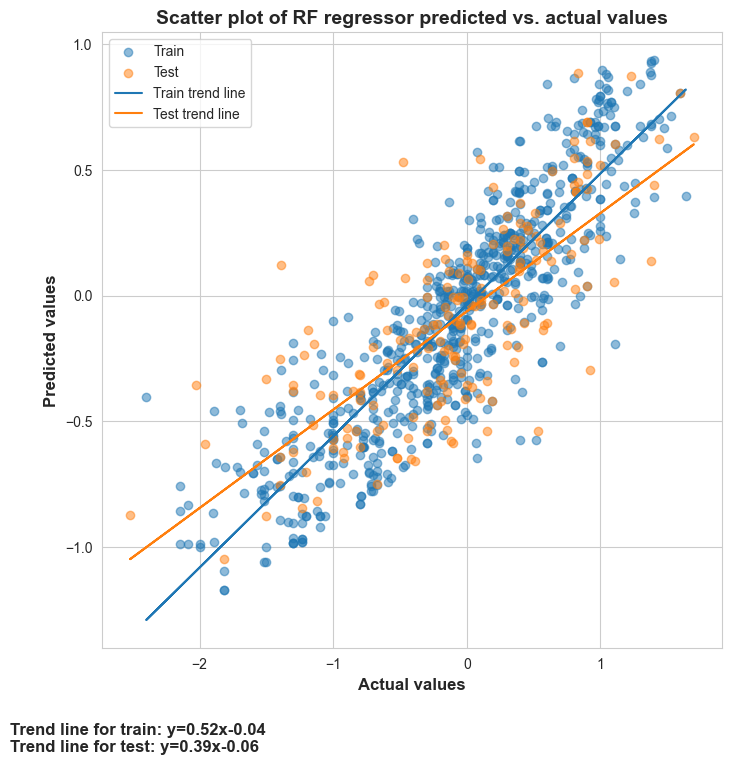

In [10]:
# Calculate coefficients for trend lines
coefficients_train = np.polyfit(regression_y_train, rf_predicted_train_y, 1)
poly_train = np.poly1d(coefficients_train)
coefficients_test = np.polyfit(regression_y_test, rf_predicted_test_y, 1)
poly_test = np.poly1d(coefficients_test)

fig, ax = plt.subplots(figsize=(8, 8))

plt.scatter(regression_y_train, rf_predicted_train_y, alpha=0.5,
            label='Train')
plt.scatter(regression_y_test, rf_predicted_test_y, alpha=0.5, label='Test')

plt.plot(regression_y_train, poly_train(regression_y_train),
         linestyle='-', label='Train trend line')
plt.plot(regression_y_test, poly_test(regression_y_test),
         linestyle='-', label='Test trend line')

plt.xlabel('Actual values', weight='bold', fontsize=12)
plt.ylabel('Predicted values', weight='bold', fontsize=12)
plt.title('Scatter plot of RF regressor predicted vs. actual values',
          weight='bold', fontsize=14)
plt.legend()
plt.grid(True)

plt.figtext(
    0.01,
    -0.02,
    'Trend line for train: y={:.2f}x{:.2f}\nTrend line for test: y={:.2f}x{:.2f}'.format(
        coefficients_train[0],
        coefficients_train[1],
        coefficients_test[0],
        coefficients_test[1]
    ),
    horizontalalignment='left',
    weight='bold',
    fontsize=12
)

plt.savefig(
    r'model_outputs\rf_regressor\pred_vs_actual.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

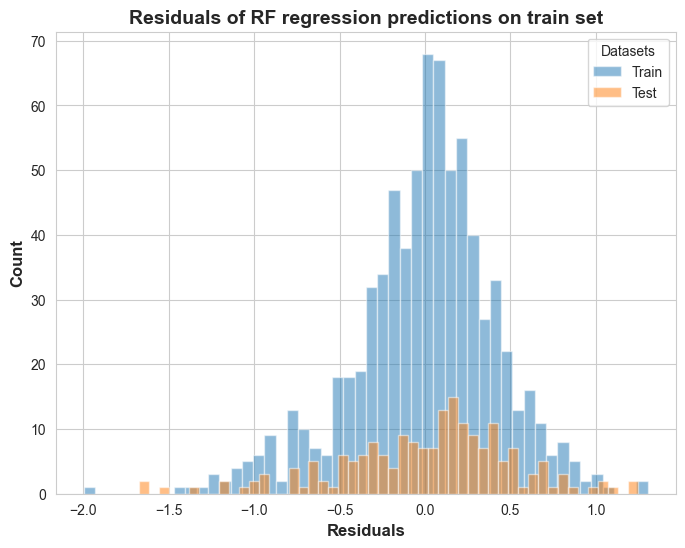

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

plt.hist(rf_residual_train, bins=50, alpha=0.5, label='Train')
plt.hist(rf_residual_test, bins=50, alpha=0.5, label='Test')

plt.xlabel('Residuals', weight='bold', fontsize=12)
plt.ylabel('Count', weight='bold', fontsize=12)
plt.title('Residuals of RF regression predictions on train set', weight='bold',
          fontsize=14)
plt.legend(title='Datasets')

plt.savefig(
    r'model_outputs\rf_regressor\residuals.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

# Classification

## Load pickles

In [12]:
best_mlp_classifier = load_pickle(
    r'model_pickles\best_mlp_classifier'
    r'.pkl')

classification_X_train = load_pickle(
    r'model_outputs\mlp_classifier\classification_X_train.pkl')
classification_y_train = load_pickle(
    r'model_outputs\mlp_classifier\classification_y_train.pkl')
classification_X_test = load_pickle(
    r'model_outputs\mlp_classifier\classification_X_test.pkl')
classification_y_test = load_pickle(
    r'model_outputs\mlp_classifier\classification_y_test.pkl')

## MLP loss curve

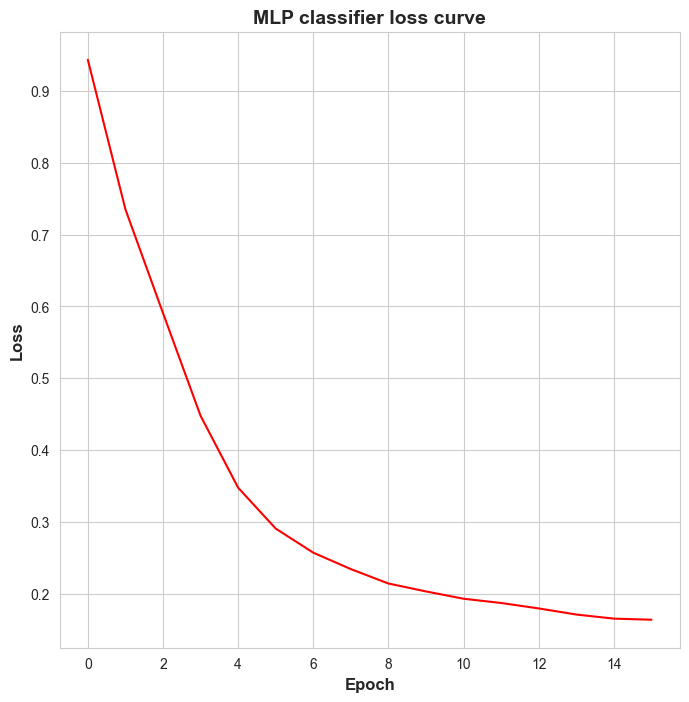

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(
    best_mlp_classifier.loss_curve_,
    color='red'
)
plt.xlabel('Epoch', weight='bold', fontsize=12)
plt.ylabel('Loss', weight='bold', fontsize=12)
plt.title('MLP classifier loss curve', weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\mlp_classifier\loss_curve.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## Performance on train vs. test sets

In [14]:
positive_label_index = 0
recall_list = []
precision_list = []
f1_list = []
accuracy_list = []
balanced_accuracy_list = []
auroc_list = []

for data_X, data_y in [[classification_X_train, classification_y_train],
                       [classification_X_test, classification_y_test]]:
    y_predict = best_mlp_classifier.predict(data_X)

    data_y_numeric = np.where(data_y == 'BBB+', 1, 0)
    y_predict_numeric = np.where(y_predict == 'BBB+', 1, 0)

    recall = recall_score(np.copy(data_y_numeric), y_predict_numeric)
    precision = precision_score(np.copy(data_y_numeric), y_predict_numeric)
    f1 = f1_score(np.copy(data_y_numeric), y_predict_numeric)
    accuracy = accuracy_score(np.copy(data_y_numeric), y_predict_numeric)
    balanced_accuracy = balanced_accuracy_score(np.copy(data_y_numeric),
                                                y_predict_numeric)

    y_proba = best_mlp_classifier.predict_proba(data_X)[:,
              positive_label_index]
    fpr, tpr, _ = roc_curve(data_y, y_proba,
                            pos_label='BBB+')
    auroc = auc(fpr, tpr)

    recall_list.append(recall)
    precision_list.append(precision)
    f1_list.append(f1)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    auroc_list.append(auroc)

performance_df = pd.DataFrame(
    {
        'Dataset': ['Train', 'Test'],
        'Recall': recall_list,
        'Precision': precision_list,
        'F1': f1_list,
        'Accuracy': accuracy_list,
        'Balanced accuracy': balanced_accuracy_list,
        'AUROC': auroc_list
    }
)

performance_df_melted = performance_df.melt(id_vars='Dataset',
                                            var_name='Metric',
                                            value_name='Value')
performance_df_melted

,Dataset,Metric,Value
0,Train,Recall,0.930346
1,Test,Recall,0.863548
2,Train,Precision,0.957393
3,Test,Precision,0.856867
4,Train,F1,0.943676
5,Test,F1,0.860194
6,Train,Accuracy,0.944458
7,Test,Accuracy,0.859786
8,Train,Balanced accuracy,0.944461
9,Test,Balanced accuracy,0.859789


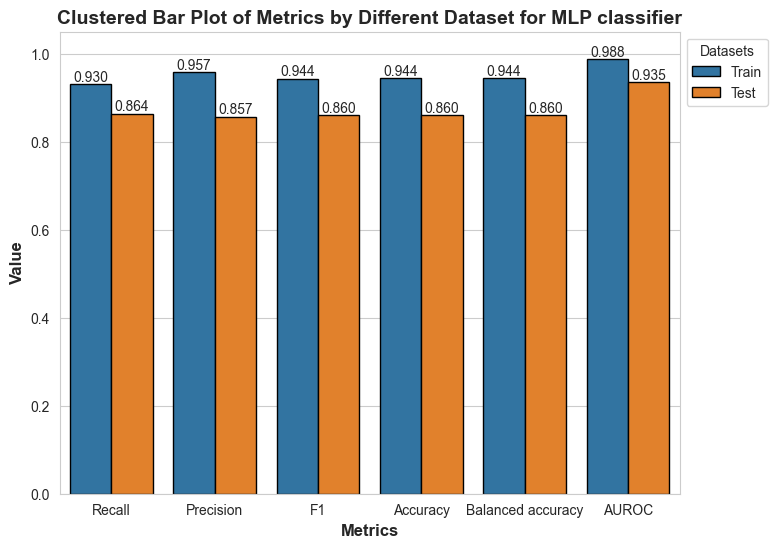

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = sns.barplot(data=performance_df_melted, x='Metric', y='Value',
                 hue='Dataset',
                 edgecolor='black')

for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%.3f'  #Round the data label to the 2 decimal places
    )
plt.ylim(0, 1.05)
plt.xlabel('Metrics', weight='bold', fontsize=12)
plt.ylabel('Value', weight='bold', fontsize=12)
plt.title('Clustered Bar Plot of Metrics by Different Dataset for MLP '
          'classifier',
          weight='bold', fontsize=14)
plt.legend(title='Datasets', loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(
    r'model_outputs\mlp_classifier\metrics.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

## ROC curve

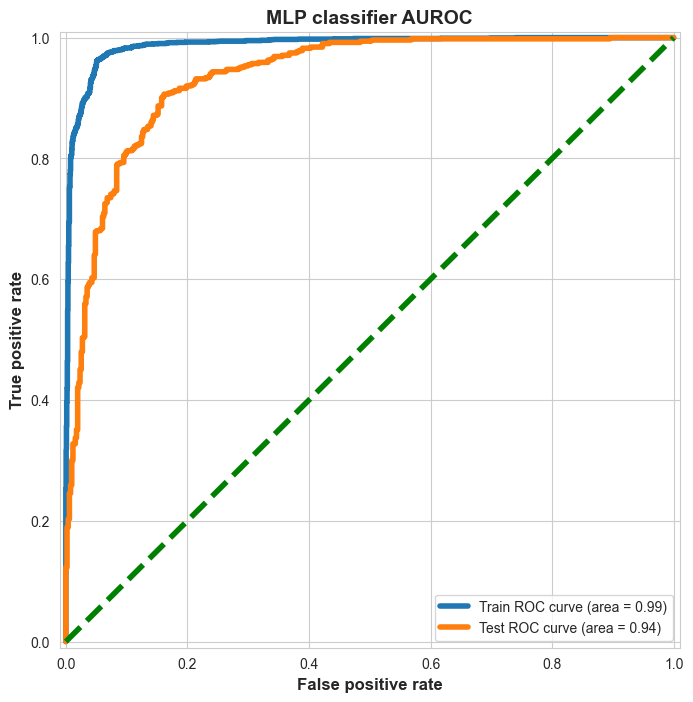

In [16]:
positive_label_index = 0
y_train_probabilities = best_mlp_classifier.predict_proba(
    classification_X_train)[:, positive_label_index]
y_test_probabilities = best_mlp_classifier.predict_proba(
    classification_X_test)[:, positive_label_index]

# Compute ROC curve and ROC area for each class
fpr_train, tpr_train, _ = roc_curve(classification_y_train,
                                    y_train_probabilities,
                                    pos_label='BBB+')
fpr_test, tpr_test, _ = roc_curve(classification_y_test, y_test_probabilities,
                                  pos_label='BBB+')
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

fig, ax = plt.subplots(figsize=(8, 8))

plt.plot(
    fpr_train,
    tpr_train,
    lw=4,
    label='Train ROC curve (area = %0.2f)' % roc_auc_train
)
plt.plot(
    fpr_test,
    tpr_test,
    lw=4,
    label='Test ROC curve (area = %0.2f)' % roc_auc_test
)
plt.plot(
    [0, 1],
    [0, 1],
    color='green',
    lw=4,
    linestyle='--'
)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False positive rate', weight='bold', fontsize=12)
plt.ylabel('True positive rate', weight='bold', fontsize=12)
plt.title('MLP classifier AUROC', weight='bold', fontsize=14)
plt.legend(loc='lower right')

plt.savefig(
    r'model_outputs\mlp_classifier\auroc.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()